# Проект "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом  разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Необходимо построить модель, которая умеет её определять. 

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

## Загрузка и первоначальный анализ данных

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, CatBoost
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
import time
import ast
import numpy as np

### Загрузка данных

In [78]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('datasets/autos.csv')

#Посмотрим, что там
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Анализ избыточных данных и информация о датасете

In [79]:
print(data.columns.to_list())

['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']


In [80]:
#Анализ нужности столбцов

#DateCrawled — дата скачивания анкеты из базы - не информативен для задачи
#VehicleType — тип автомобильного кузова - влияет на цену
#RegistrationYear — год регистрации автомобиля - влияет на цену
#Gearbox — тип коробки передач - влияет на цену
#Power — мощность (л. с.) - влияет на цену
#Model — модель автомобиля - влияет на цену
#Kilometer — пробег (км) - влияет на цену
#RegistrationMonth — месяц регистрации автомобиля - не принципиально. Оставим год только
#FuelType — тип топлива - влияет на цену
#Brand — марка автомобиля - влияет на цену
#Repaired — была машина в ремонте или нет - влияет на цену
#DateCreated — дата создания анкеты - не влияет на цену
#NumberOfPictures — количество фотографий автомобиля - влияет на покупку авто, но не на цену
#PostalCode — почтовый индекс владельца анкеты (пользователя) - не влияет на цену
#LastSeen — дата последней активности пользователя - не влияет на цену

cols = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 
        'Kilometer', 'FuelType', 'Brand', 'Repaired']
df = data[cols]

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Анализ данных

#### Столбец Цена

In [82]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

In [83]:
#Уберем нулевые значения по цене. Их нечем заполнить
_ = len(df)
df = df.query('Price>0')
print('В ходе преобразования удалено', (_-len(df)), 'строк')  

В ходе преобразования удалено 10772 строк


In [84]:
#Удалять выбросы по цене имеет смысл в привязке к модели и марке, заменим Nan в моделях и марках на наименование
df['Model'] = data['Model'].fillna('Model_na')
df['Brand'] = data['Brand'].fillna('Brand_na')

d = pd.DataFrame()
s = list()

for i in list(df['Brand'].unique()):
    _ = list(df.query('Brand==@i')['Model'].unique())
    _.insert(0, i)
    s.append(_)

t_ = 0
for i in range(len(s)):
    for j in range(1,len(s[i])):
        d.loc[t_,'Brand'] = s[i][0]
        d.loc[t_,'Model'] = s[i][j]
        n1= s[i][0]
        n2 =s[i][j]
        d.loc[t_,'q1'] = int(df.query('Brand==@n1&Model==@n2')['Price'].quantile([.1]))
        d.loc[t_,'q2'] = int(df.query('Brand==@n1&Model==@n2')['Price'].quantile([.9]))
        d.loc[t_,'quant'] = len(df.query('Brand==@n1&Model==@n2')) #количество, моржет пригодиться
        d.loc[t_, 'vehicle'] = df.query('Brand==@n1&Model==@n2')['VehicleType'].mode()[0] #заодно наиболее частый корпус
        d.loc[t_, 'gearbox'] = df.query('Brand==@n1&Model==@n2')['Gearbox'].mode()[0] #коробка
        d.loc[t_, 'fueltype'] = df.query('Brand==@n1&Model==@n2')['FuelType'].mode()[0]#тоnливо
        d.loc[t_, 'power'] = df.query('Brand==@n1&Model==@n2')['Power'].mean()#занесем среднее значение мощности авто
        t_+=1
        

In [85]:
#удалим стоимости, которые являются выбросами, т.к. эти авто нельзя назвать характерной машиной
#если сишком дешевая, то, возможно, по цене железа, если слишком дорогая, то сильно модернизированная
_ = len(df)
for i in range (len(d)):
    n1 = d['Brand'][i]
    n2 = d['Model'][i]
    n3 = d['q1'][i]
    n4 = d['q2'][i]
    
    df = df.query('not(Brand==@n1&Model==@n2&(Price<=@n3 or Price>=@n4))')
print('В ходе преобразования удалено', (_-len(df)), 'строк')    

В ходе преобразования удалено 70649 строк


#### Прочие столбцы

In [86]:
df.isnull().sum()

Price                   0
VehicleType         24860
RegistrationYear        0
Gearbox             12201
Power                   0
Model                   0
Kilometer               0
FuelType            21588
Brand                   0
Repaired            50176
dtype: int64

1. VehicleType. Восстановим пропущенные значения укажем наиболее частое значение из таблицы по марке и модели.
2. Gearbox. Для всех NaN укажем наиболее частое значение из таблицы по марке и модели.
3. FuelType - аналогично
4. Repaired - поставим по всем значениям, где не указано - 'yes'. 

In [87]:
#e = df.copy()

In [88]:
df.fillna({'VehicleType':0},inplace=True)
df.fillna({'Gearbox':0},inplace=True)
df.fillna({'FuelType':0},inplace=True)
df.fillna({'Repaired':'yes'},inplace=True)

In [89]:
def values_character(d, row, col):
    val = row[col]
    if col == 1: #vehicle
        t = 5
    elif col== 3:  #gear  
        t = 6
    elif col== 7:  #fuel  
        t = 7    
    elif col== 4:  #power  
        t = 8    
        
    if val==0:
        n1 = row[8]
        n2 = row[5]    
        val = d.iloc[:,t][d.query('Brand==@n1&Model==@n2').index[0]] 
    return val

In [90]:
df['VehicleType'] = df.apply(lambda row: values_character(d, row, 1), axis=1)
df['Gearbox'] = df.apply(lambda row: values_character(d, row, 3), axis=1)
df['FuelType'] = df.apply(lambda row: values_character(d, row, 7), axis=1)

In [91]:
#проверим, что получилось
df.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [92]:
#Посмотрим столбец Power на общую логику
print("Количество авто с двигателями больше 500 л.с.", len(df.query('Power>500')))
print("Количество авто с двигателями равными 0 л.с.", len(df.query('Power==0')))

#Все, что больше 500 удалим, все 0 заменим на среднее по Марке и модели. 
#Идеально еще и по типу корпуса и топливу, но это будет очень долго
#больше изменений делать не будем, т.к. машины есть разные и л.с. тоже разные
df = df.query('Power<500')

Количество авто с двигателями больше 500 л.с. 308
Количество авто с двигателями равными 0 л.с. 26512


In [93]:
df['Power'] = df.apply(lambda row: values_character(d, row, 4), axis=1)

<AxesSubplot: >

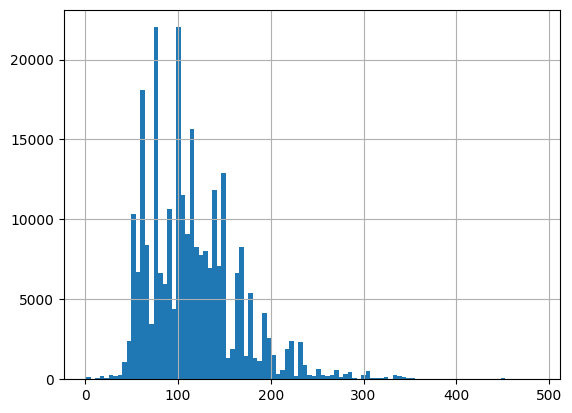

In [94]:
df['Power'].hist(bins=100)

<AxesSubplot: >

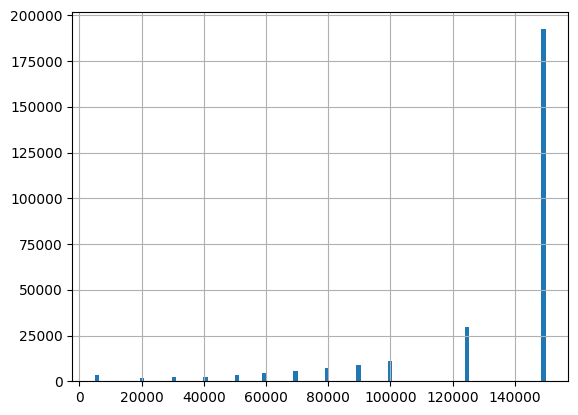

In [95]:
#посмотрим столбец с пробегом
df['Kilometer'].hist(bins=100)

In [96]:
df['Kilometer'].value_counts()

150000    192363
125000     29722
100000     11334
90000       8691
80000       7153
70000       5648
60000       4556
50000       3301
5000        3169
40000       2376
30000       2071
20000       1821
10000        421
Name: Kilometer, dtype: int64

Вывод: получается, что километраж - категориальный признак, для упрощения в дальнейшем этот столбец категоризируем.

In [97]:
#Посмотрим год регистрации автомобилей. Этот год должен быть в границах 1900 - дата последнего объявления
data['DateCreated']= pd.to_datetime(data['DateCreated'])
_= data['DateCreated'].dt.year.max()
print('Количество объявлений с датой выпуска меньше 1900 года', len(df.query('RegistrationYear<1900')))
print('Количество объявлений с датой выпуска больше последней даты скачивания - ',_, len(df.query('RegistrationYear>@_')))

#df['RegistrationYear'].value_counts()

Количество объявлений с датой выпуска меньше 1900 года 19
Количество объявлений с датой выпуска больше последней даты скачивания -  2016 11801


In [98]:
df.query('RegistrationYear>@_')['RegistrationYear'].value_counts()

2017    8368
2018    3381
2019      10
9999       6
5000       5
6000       4
9000       2
5911       2
5555       2
3000       2
4500       2
7000       1
2500       1
2800       1
7800       1
9450       1
2290       1
8500       1
4800       1
3800       1
3700       1
5900       1
5300       1
4100       1
2200       1
8888       1
3200       1
7100       1
Name: RegistrationYear, dtype: int64

Вывод: год выпуска очень важен, объявления с датой 2017, 2018, 2019 придется удалить, хоть их и много. Непонятно, что ставить. Прочие даты - явные ошибки, но их немного

In [99]:
#Выше я определил, что дата скачивания базы - 2016, соответственно, даты выпуска больше 2016 никак не могут быть. 
#Год выпуска меньше 1900 не может быть. Соответственно ставим границы выпуска - 1900-2016  
_ = len(df)

df = df.query('1900<RegistrationYear<2017')
print('В ходе преобразования удалено', (_-len(df)), 'строк')   

В ходе преобразования удалено 11820 строк


In [100]:
#Год выпуска тоже похож на категориальное значение.Уберем совсем униальные, если мх немного
_ = pd.DataFrame(df['RegistrationYear'].value_counts())
_.query('RegistrationYear==1')

,RegistrationYear
1944,1
1930,1
1925,1
1931,1
1948,1
1936,1
1946,1


In [101]:
#удалим их
_= list(_.query('RegistrationYear==1').index)

In [102]:
df=df.query('RegistrationYear!=@_')

In [103]:
#Удалим совсем уникальые модели
_ = pd.DataFrame(df['Model'].value_counts())
print('Количество совсем уникальных моделей', len(_.query('Model==1')))
_= list(_.query('Model==1').index)
df=df.query('Model!=@_')

Количество совсем уникальных моделей 2


In [104]:
#Посмотрим потерю данных после псех перестановок
len(df)/len(data)

0.7359475574895096

Вывод по этапу:
1. Была изучена таблица данных.
2. Выведены аномальные и пропущенные значения.
3. Отобраны небходимые столбцы для обучения модели.
4. Заполнены пропуски в столбцах и удалены некорректные значения.
5. Постарались сохранить как можно больше данных.Потеря (27%) значительна, но учитывая размер датасета, вполне приемлема

## Преобразование и кодирование данных

In [105]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345)
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']

X_t = df_test.drop('Price', axis=1)
y_t = df_test['Price']

X_test, X_valid, y_test, y_valid = train_test_split(X_t, y_t, test_size=0.5, random_state=12345)

In [106]:
#X = df.drop("Price", axis=1)
#y = df["Price"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [107]:
numeric_features = ['Power']

In [108]:
categorical_features = ['VehicleType', 'FuelType','Brand', 'Model','Kilometer', 'RegistrationYear', 'Gearbox','Repaired']

In [109]:
mask_prep = ColumnTransformer(transformers=[("categorical", OrdinalEncoder(), categorical_features),
                                            ("numerical", StandardScaler(), numeric_features)])

In [110]:
#s = X.columns.get_indexer(categorical_features)

In [111]:
X_train_p = pd.DataFrame(mask_prep.fit_transform(X_train))

In [112]:
X_valid_p = pd.DataFrame(mask_prep.transform(X_valid)) 
X_test_p = pd.DataFrame(mask_prep.transform(X_test))

## Прогнозирование

In [113]:

def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return s,m,h

In [114]:
def grid_search(param, X,y):

    cv = KFold(5, shuffle=True, random_state=12345)
    GridModel = GridSearchCV(estimator=param['model'], param_grid=param['params'], cv=cv, scoring='neg_mean_squared_error', verbose=0)
    GridModel.fit(X, y)
    
    return (-1*GridModel.best_score_)**0.5, GridModel.best_params_

### Подбор параметров grid_search

In [115]:
#Создадим список моделей
#LGBMRegressor()
p1 = {'learning_rate': [0.1, 0.5],
                    'num_leaves': [100, 200], 
                    'random_state': [12345],
                    'force_col_wise': [True],
                    'verbose':[0]}

p2 = {'model':DecisionTreeRegressor(),
      'name': 'DecisionTreeRegressor',
      'params': {'max_depth': [2, 3, 15, 20],
                 'min_samples_split': [2, 4, 6],
                 'criterion': ['squared_error'],
                 'random_state': [12345]}}

#RandomForestRegressor()
p3 = {'model':RandomForestRegressor(),
      'name': 'RandomForestRegressor',
      'params': {'n_estimators': [10, 20, 50],  
                 'max_features': ['sqrt'],
                 'criterion': ['squared_error'],
                 'random_state': [12345]}}


#CatBoostRegressor()
p4 = {'learning_rate': [0.1, 0.5, 0.8],
      'iterations':[50,100,400],
      'random_state': [12345],
      'verbose':[0]}




param = [p2, p3]

In [116]:
%%time
#Сначала определим простые модели

d1 = pd.DataFrame()
for i in range(len(param)):
    start = time.time() 
    score, best_p = grid_search(param[i], X_train_p, y_train)
    d1.loc[i, 'model'] = param[i]['name']
    d1.loc[i, 'score'] = score
    d1.loc[i, 'params'] = str(best_p)
    end = time.time()
    s,m,h = exec_time(start, end)
    print(param[i]['name'], 'Execution Time: ' + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   

DecisionTreeRegressor Execution Time: 00:00:22
RandomForestRegressor Execution Time: 00:01:41
CPU times: total: 2min 2s
Wall time: 2min 2s


In [117]:
%%time
#Модель Catboost
train_pool = Pool(X_train, y_train, cat_features=X_train.columns.get_indexer(categorical_features))
cv = KFold(5, shuffle=True, random_state=12345)
model = CatBoostRegressor()
grid_search_result = model.grid_search(p4,train_pool, cv=cv, verbose=0 )



bestTest = 1519.251426
bestIteration = 49


bestTest = 1386.263847
bestIteration = 49


bestTest = 1383.145224
bestIteration = 49


bestTest = 1439.470875
bestIteration = 99


bestTest = 1350.309494
bestIteration = 99


bestTest = 1348.310346
bestIteration = 99


bestTest = 1322.571022
bestIteration = 399


bestTest = 1289.556352
bestIteration = 399


bestTest = 1307.004999
bestIteration = 397

Training on fold [0/5]

bestTest = 1304.343918
bestIteration = 397

Training on fold [1/5]

bestTest = 1298.19956
bestIteration = 394

Training on fold [2/5]

bestTest = 1290.150928
bestIteration = 386

Training on fold [3/5]

bestTest = 1280.37753
bestIteration = 399

Training on fold [4/5]

bestTest = 1290.378922
bestIteration = 399

CPU times: total: 26min 50s
Wall time: 8min 1s


In [118]:
#Занесем результат в таблицу
d1.loc[2, 'model'] = 'CatBoost'
d1.loc[2, 'score'] = pd.DataFrame(grid_search_result['cv_results'])['train-RMSE-mean'].min()
d1.loc[2, 'params'] = str(grid_search_result['params'])

In [119]:
%%time
#Модель LGBMRegressor()
X_train_LGBMR = X_train
X_train_LGBMR[categorical_features]=X_train[categorical_features].astype('category')
cv = KFold(5, shuffle=True, random_state=12345)
GridModel = GridSearchCV(estimator = LGBMRegressor(), param_grid=p1, cv=cv, scoring='neg_mean_squared_error', verbose=0)
GridModel.fit(X_train_LGBMR, y_train)

CPU times: total: 1min 43s
Wall time: 29.3 s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(),
             param_grid={'force_col_wise': [True], 'learning_rate': [0.1, 0.5],
                         'num_leaves': [100, 200], 'random_state': [12345],
                         'verbose': [0]},
             scoring='neg_mean_squared_error')

In [120]:
#Занесем результат в таблицу
d1.loc[3, 'model'] = 'LGBMRegressor'
d1.loc[3, 'score'] = (-1*GridModel.best_score_)**0.5
d1.loc[3, 'params'] = str(GridModel.best_params_)

In [121]:
#отобразим таблицу
d1

,model,score,params
0,DecisionTreeRegressor,1544.804446,"{'criterion': 'squared_error', 'max_depth': 15..."
1,RandomForestRegressor,1323.780422,"{'criterion': 'squared_error', 'max_features':..."
2,CatBoost,1193.911672,"{'random_seed': 12345, 'verbose': 0, 'iteratio..."
3,LGBMRegressor,1251.311357,"{'force_col_wise': True, 'learning_rate': 0.1,..."


Вывод по подбору параметров:
1. Лучше всего результат у модели CatBoost
2. Подбор параметров внутренними средствами модели CatBoost - это очень долго
3. Категорийные признауки Catboost и LGBMR обработаны внутренними средствами моделей, а catboost еще и подбор параметров осуществлен внутренним GridSearch

### Определение лучшей модели по совокупности характеристик

In [122]:
d1['fit_time'] = np.nan
d1['predict_time'] = np.nan
d1['test_score'] = np.nan

In [123]:
#DecisionTreeRegressor()
model1 = DecisionTreeRegressor()
model1.set_params(**ast.literal_eval(d1['params'][0]))
start = time.time()
model1.fit(X_train_p, y_train)
end = time.time()
s,m,h = exec_time(start, end)
d1['fit_time'][0] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

start = time.time()
y_pred = model1.predict(X_valid_p)
end = time.time()
s,m,h = exec_time(start, end)
d1['predict_time'][0] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
d1['test_score'][0] = mean_squared_error(y_valid, y_pred) ** 0.5

In [124]:
#RandomForestRegressor
model1 = RandomForestRegressor()
model1.set_params(**ast.literal_eval(d1['params'][1]))
start = time.time()
model1.fit(X_train_p, y_train)
end = time.time()
s,m,h = exec_time(start, end)
d1['fit_time'][1] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

start = time.time()
y_pred = model1.predict(X_valid_p)
end = time.time()
s,m,h = exec_time(start, end)
d1['predict_time'][1] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
d1['test_score'][1] = mean_squared_error(y_valid, y_pred) ** 0.5

In [125]:
#Catboost
model1 = CatBoostRegressor()
valid_pool = Pool(X_valid, cat_features=X_valid.columns.get_indexer(categorical_features))
#valid_pool = X_valid
model1.set_params(**ast.literal_eval(d1['params'][2]))
start = time.time()
model1.fit(train_pool)
end = time.time()
s,m,h = exec_time(start, end)
d1['fit_time'][2] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

start = time.time()
y_pred = model1.predict(valid_pool)
end = time.time()
s,m,h = exec_time(start, end)
d1['predict_time'][2] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
d1['test_score'][2] = mean_squared_error(y_valid, y_pred) ** 0.5

In [126]:
#LGBMRegressor
X_valid_LGBMR = X_valid
X_valid_LGBMR[categorical_features]=X_valid[categorical_features].astype('category')

model1 = LGBMRegressor()
model1.set_params(**ast.literal_eval(d1['params'][3]))
start = time.time()
model1.fit(X_train_LGBMR, y_train)
end = time.time()
s,m,h = exec_time(start, end)
d1['fit_time'][3] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

start = time.time()
y_pred = model1.predict(X_valid_LGBMR)
end = time.time()
s,m,h = exec_time(start, end)
d1['predict_time'][3] = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
d1['test_score'][3] = mean_squared_error(y_valid, y_pred) ** 0.5

In [127]:
d1

,model,score,params,fit_time,predict_time,test_score
0,DecisionTreeRegressor,1544.804446,"{'criterion': 'squared_error', 'max_depth': 15...",00:00:01,00:00:00,1535.148757
1,RandomForestRegressor,1323.780422,"{'criterion': 'squared_error', 'max_features':...",00:00:14,00:00:01,1292.735730
2,CatBoost,1193.911672,"{'random_seed': 12345, 'verbose': 0, 'iteratio...",00:00:56,00:00:00,1287.640918
3,LGBMRegressor,1251.311357,"{'force_col_wise': True, 'learning_rate': 0.1,...",00:00:02,00:00:00,1248.557683


Вывод по разделу: лучшие показатели на тестировочной выборке показала модель catboost, на тестовой - LGBMRegressor. По соотношению времени и качества результата лучшая модель получилась LGBMRegressor. Эту модель и будем использовать для предсказаний на тестовой выборке

In [128]:
X_test_LGBMR = X_test
X_test_LGBMR[categorical_features]=X_test[categorical_features].astype('category')

model1 = LGBMRegressor()
model1.set_params(**ast.literal_eval(d1['params'][3]))
start = time.time()
model1.fit(X_train_LGBMR, y_train)
start = time.time()
y_pred = model1.predict(X_test_LGBMR)
print('Значение RMSE на тестовой выборке', mean_squared_error(y_test, y_pred) ** 0.5)

Значение RMSE на тестовой выборке 1241.1143570086776


Вывод по исследованию:
1. Мы преобразовали данные, потеря данных составила 27%
2. Посчитали, что большая часть данных категорийная, в частности, такие как километраж и год выпуска. Преобразовали OrdinalEncorder. Если бы датасет не был бы таким большим, то имело смысл Ohe
3. Исследовали 4 модели с подбором гиперпараметров и кросс-валидацией - LGBMRegressor, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor
4. Измерили время выполнения всех моделей. Получились следующие данные
    LGBMRegressor Execution Time: 00:00:6, 
    DecisionTreeRegressor Execution Time: 00:00:1, 
    RandomForestRegressor Execution Time: 00:00:14, 
    CatBoostRegressor Execution Time: 00:00:57, 
5. По соотношению времени и качества результата лучшая модель получилась LGBMRegressor.